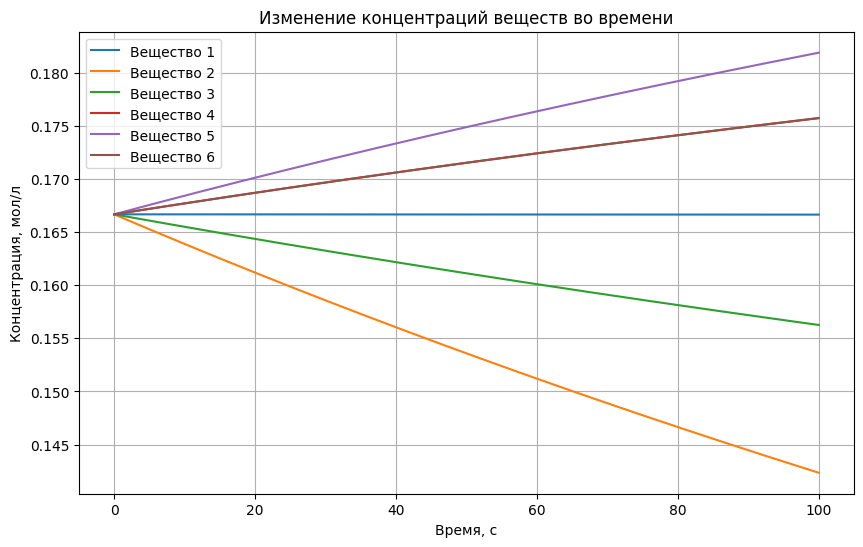

100000
[0.16666667 0.16666677 0.16666688 ... 0.17572281 0.17572289 0.17572297]
6


In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt



# Константы
N = 6
M = 5
A = np.array([100000000, 90000000, 85000000, 110000000, 95000000])  # предэкспоненциальный множитель
E = np.array([70000, 60000, 55000, 80000, 75000])  # энергия активации (Дж/моль)
R = 8.314  # универсальная газовая постоянная
T = 300  # температура (К)

# Стехиометрическая матрица
MATR = np.array([ 
    [-2, -1,  1,  1,  0,  0],
    [ 0, -2,  1,  0,  2,  0],
    [ 0, -1, -2,  1,  0,  1],
    [ 1,  0,  0, -2,  1,  0],
    [ 1,  0,  0,  0, -2,  1]
])

# МАтрица порядков реакций
MATR_PLUS = np.where(MATR < 0, -MATR, 0)

# Начальные концентрации
C0 = np.full(N, 1 / N)

# Вычисление констант скоростей
k = A * np.exp(-E / (R * T))

# Дифференциальные уравнения
def dCdt(t, C):
    r = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(len(A))])  # Скорость для каждой реакции
    dC = MATR.T @ r  # Изменение концентраций
    return dC

# Численное решение
time_span = (0, 100)  # Время реакции (с)
time_points = np.linspace(0, 100, 100000)  # Точки для вывода
solution = solve_ivp(dCdt, time_span, C0, t_eval=time_points)

# Графики концентраций
plt.figure(figsize=(10, 6))
for i, C in enumerate(solution.y):
    plt.plot(solution.t, C, label=f'Вещество {i+1}')
plt.xlabel('Время, с')
plt.ylabel('Концентрация, мол/л')
plt.title('Изменение концентраций веществ во времени')
plt.legend()
plt.grid()
plt.show()


print(len(C))
print(C)
print(len(solution.y))

In [37]:
print(solution.y[:, 9999])
print(solution.y.T[9999])

[0.16666341 0.16388149 0.16549344 0.16769584 0.16841766 0.16769592]
[0.16666341 0.16388149 0.16549344 0.16769584 0.16841766 0.16769592]


Начальные концентрации:        [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Сумма концентрций веществ:  0.9999999999999999


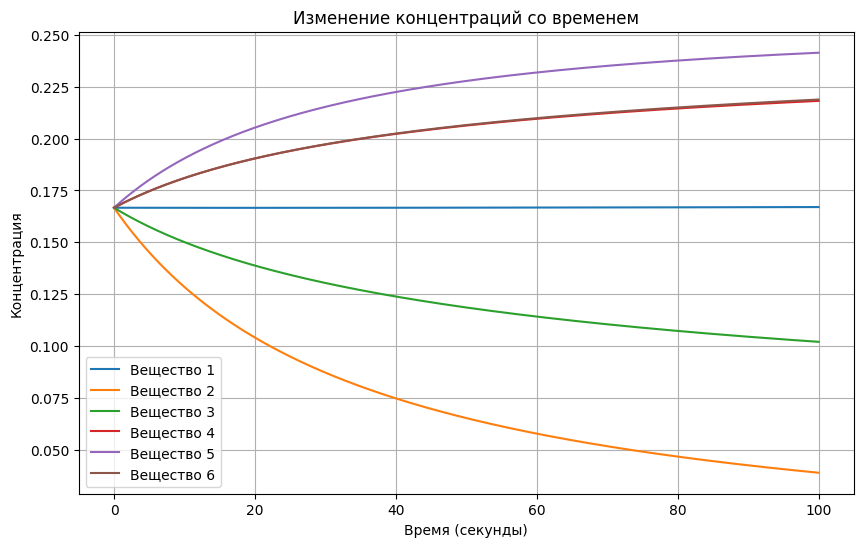

Концентрации после 100 секунд: [0.16699309 0.03907592 0.10210201 0.21811033 0.24130689 0.21876537]
Сумма концентрций веществ:  0.9863536047437009


In [16]:
import numpy as np
import matplotlib.pyplot as plt
# import random

# random.seed(1)

# Константы
N = 6                                                               # веществ
M = 5                                                               # реакций
A = np.array([100000000, 90000000, 85000000, 110000000, 95000000])
Ea= np.array([70000, 60000, 55000, 80000, 75000])
R = 8.314
T = 300
vr_time = 100
H = 0.001
MATR = np.array([
    [-2, -1, 1, 1, 0, 0],
    [0, -2, 1, 0, 2, 0],
    [0, -1, -2, 1, 0, 1],
    [1, 0, 0, -2, 1, 0],
    [1, 0, 0, 0, -2, 1]
])

# Матрица порядков реакций
MATR_PLUS = np.where(MATR < 0, -MATR, 0)
k = A * np.exp(-Ea / (R * T)) * (T**0.5)

# Переменные, будут заводиться отдельно
C = np.full(N, 1 / N)
print("Начальные концентрации:       ", C)
print("Сумма концентрций веществ: ", sum(C))

# Список для хранения концентраций на каждом шаге времени
concentration_history = [C.copy()]

def dC_dt(C):
    W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(M)])  # Скорость для каждой реакции
    dC = MATR.T @ W  # Изменение концентраций
    return dC

time_steps = int(vr_time / H)
for _ in range(time_steps):
    dC = dC_dt(C)
    C += dC * H
    concentration_history.append(C.copy())

concentration_history = np.array(concentration_history)

# Построение графика
time = np.linspace(0, vr_time, time_steps + 1)
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(time, concentration_history[:, i], label=f"Вещество {i+1}")

plt.title("Изменение концентраций со временем")
plt.xlabel("Время (секунды)")
plt.ylabel("Концентрация")
plt.legend()
plt.grid()
plt.show()

print(f"Концентрации после {vr_time} секунд: {C}")
print("Сумма концентрций веществ: ", sum(C))
